# Presidential Election Favorability 2024 

## Overview
This notebook uses classification modeling to predict the likelihood of the next President being Kamala Harris or Donald Trump based on current favorability ratings.

## Objectives
- Predict whether the politician is Kamala Harris or Donald Trump.
- Calculate the accuracy of the model.
- Visualize the results using `matplotlib`.

## Tools Used
- numpy
- pandas
- scikit-learn
- tensorflow
- imblearn
- matplotlib

## Dataset
This dataset provides detailed favorability ratings for both candidates. For this analysis, we focus on the following.
- Politician (Kamala Harris or Donald Trump)
- Favorability

## Model
We will use the following models for this task.
- TensorFlow Sequential

## Credits
**Dataset Author:**
* FiveThirtyEight

**Model Author:**  
* Kevin Thomas

**Date:**  
* 07-26-24  

**Version:**  
* 1.0

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Input, LeakyReLU # type: ignore
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

## Step 1: Data Preparation

In [2]:
# Load the dataset
data = pd.read_csv('favorability_polls_07-26-24.csv')

# Filter the dataset to include only Kamala Harris and Donald Trump
filtered_data = data[(data['politician'] == 'Kamala Harris') | (data['politician'] == 'Donald Trump')]

# Fill NaN values with the mean of the column in a new DataFrame
filtered_data = filtered_data.copy()  # Create a copy of the DataFrame to avoid chained assignment
filtered_data['favorable'] = filtered_data['favorable'].fillna(filtered_data['favorable'].mean())
filtered_data['unfavorable'] = filtered_data['unfavorable'].fillna(filtered_data['unfavorable'].mean())

# Separate the majority and minority classes
harris_data = filtered_data[filtered_data['politician'] == 'Kamala Harris']
trump_data = filtered_data[filtered_data['politician'] == 'Donald Trump']

# Ensure equal number of samples for both candidates
min_samples = min(harris_data.shape[0], trump_data.shape[0])
harris_resampled = resample(harris_data, replace=False, n_samples=min_samples, random_state=42)
trump_resampled = resample(trump_data, replace=False, n_samples=min_samples, random_state=42)

# Combine the resampled datasets
balanced_data = pd.concat([harris_resampled, trump_resampled])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42)

# Prepare data for modeling
X_balanced = balanced_data[['favorable']].values
y_balanced = balanced_data['politician'].values

## Step 2: Feature Engineering

In [3]:
# One-hot encode the politician column
encoder = OneHotEncoder(sparse_output=False)
y_balanced_encoded = encoder.fit_transform(balanced_data[['politician']])

# Split data into training and testing sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced_encoded, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_test_balanced_scaled = scaler.transform(X_test_balanced)

# Calculate class weights to address imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_balanced_encoded, axis=1)),
    y=np.argmax(y_balanced_encoded, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

# Print class weights
print("Class weights:", class_weight_dict)

Class weights: {0: 1.0, 1: 1.0}


## Step 3: Modeling

In [4]:
# Build the model
model_balanced = Sequential([
    Input(shape=(1,)),
    Dense(16),
    LeakyReLU(alpha=0.01),
    Dense(8),
    LeakyReLU(alpha=0.01),
    Dense(2, activation='softmax')
])

# Compile the model
model_balanced.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the sampling strategy to control the amount of resampling
sampling_strategy = 'minority'  

# Apply SMOTE to balance the training data with adjustable parameters
smote = SMOTE(
    sampling_strategy=sampling_strategy,
    k_neighbors=4,  # Adjust the number of neighbors for SMOTE
    random_state=42
)
X_train_balanced_smote, y_train_balanced_smote = smote.fit_resample(X_train_balanced_scaled, np.argmax(y_train_balanced, axis=1))

# Convert y_train_balanced_smote to one-hot encoding
y_train_balanced_smote_encoded = tf.keras.utils.to_categorical(y_train_balanced_smote)

# Train the model with the resampled data
history_balanced = model_balanced.fit(
    X_train_balanced_smote, y_train_balanced_smote_encoded,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_balanced_scaled, y_test_balanced),
    class_weight=class_weight_dict
)

# Evaluate the model
test_loss_balanced, test_accuracy_balanced = model_balanced.evaluate(X_test_balanced_scaled, y_test_balanced)
print(f'Test Accuracy with Balanced Data: {test_accuracy_balanced:.4f}')

Epoch 1/50


/Users/kevinthomas/Documents/data-science/venv/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5222 - loss: 0.6901 - val_accuracy: 0.6038 - val_loss: 0.6808
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - accuracy: 0.5784 - loss: 0.6817 - val_accuracy: 0.5974 - val_loss: 0.6797
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.5607 - loss: 0.6844 - val_accuracy: 0.5942 - val_loss: 0.6780
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.5853 - loss: 0.6830 - val_accuracy: 0.5942 - val_loss: 0.6756
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.5853 - loss: 0.6796 - val_accuracy: 0.5942 - val_loss: 0.6744
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.5946 - loss: 0.6775 - val_accuracy: 0.5942 - val_loss: 0.6735
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.5993 - loss: 0.6751 - val_accuracy: 0.5751 - val_loss: 0.6739
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.5773 - loss: 0.6782 - val_accuracy: 0.5751 - val_lo

## Step 4: Visualization

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


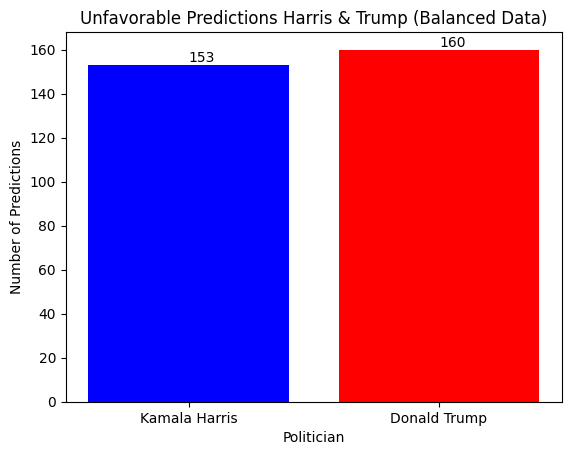

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560 (2.19 KB)

 Trainable params: 186 (744.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 374 (1.46 KB)

Test Accuracy with Balanced Data: 0.5751


In [5]:
# Predict on the test set
y_pred_balanced = model_balanced.predict(X_test_balanced_scaled)

# Replace NaN values with zero (if any)
y_pred_balanced = np.nan_to_num(y_pred_balanced)

# Decode the one-hot encoded predictions
y_pred_balanced_decoded = encoder.inverse_transform(y_pred_balanced)

# Calculate the number of times each politician was predicted
harris_count_balanced = (y_pred_balanced_decoded == 'Kamala Harris').sum()
trump_count_balanced = (y_pred_balanced_decoded == 'Donald Trump').sum()

# Plot the bar plot for balanced predictions
fig, ax = plt.subplots()
politicians = ['Kamala Harris', 'Donald Trump']
counts = [harris_count_balanced, trump_count_balanced]
bars = ax.bar(politicians, counts, color=['blue', 'red'])

# Add text annotations
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  # va: vertical alignment

# Add title and labels
ax.set_title('Unfavorable Predictions Harris & Trump (Balanced Data)')
ax.set_ylabel('Number of Predictions')
ax.set_xlabel('Politician')
plt.show()

# Print the model summary
model_balanced.summary()

# Print the model accuracy
print(f'Test Accuracy with Balanced Data: {test_accuracy_balanced:.4f}')

## Step 5: Inference

In [6]:
# Determine the ultimate winner
ultimate_winner_balanced = 'Kamala Harris' if harris_count_balanced > trump_count_balanced else 'Donald Trump'

# Print results
print(f'Kamala Harris predictions: {harris_count_balanced}')
print(f'Donald Trump predictions: {trump_count_balanced}')
print(f'Ultimate Winner: {ultimate_winner_balanced}')

Kamala Harris predictions: 153
Donald Trump predictions: 160
Ultimate Winner: Donald Trump
